## read raw data

In [13]:
from loguru import logger
from transformers import AutoTokenizer
from torchtext.data import get_tokenizer
import os

class Options:
    def __init__(self, name) -> None:
        self.name= name
    def name(self):
        return self.name

# project gloal parameter
options = Options("Model")
options.base_path="/home/yang/github/fuzzys2s/"
options.SOS = 0 # start of sentence
options.EOS = 1 # End of sentence
options.PAD = 2 # padding token
options.UNK = 3 # unknown token, word frequency low

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<sos>":options.SOS, "<eos>":options.EOS, "<pad>":options.PAD,"<unk>":options.UNK}
        self.word2count = {"<sos>":1, "<eos>":1, "<pad>":1,"<unk>":1}
        self.index2word = {options.SOS: "<sos>", options.EOS: "<eos>", options.PAD:"<pad>",options.UNK: "<unk>"}
        self.n_words = 4  # Count PAD , SOS and EOS
        self.feature_max = [] # max value of feature
        self.feature_min = [] # min value of feature
        self.line_max = 0 # max length of sentence

    def addTokens(self, tokens):
        for word in tokens:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def build_vocab(vocab_src, vocab_tgt, tokens):
    for sentence in tokens:
        src = sentence[0]
        tgt = sentence[1]
        vocab_src.addTokens(src)
        vocab_tgt.addTokens(tgt)
        if len(src) > vocab_src.line_max:
            vocab_src.line_max = len(src)
        if len(tgt) > vocab_tgt.line_max:
            vocab_tgt.line_max = len(tgt)
    return vocab_src, vocab_tgt

def get_base_tokenizer(name):
    tokenizer_path = options.base_path+"output/"+name+"/"
    if os.path.exists(tokenizer_path):
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    else:
        tokenizer = AutoTokenizer.from_pretrained(name)
        tokenizer.save_pretrained(tokenizer_path)
    return tokenizer.tokenize

def gen_token_vectors(vocab_src, vocab_tgt, tokens):
    token_vectors =[]
    for row in tokens:
        src = [vocab_src.word2index[word]  for word in row[0]]
        tgt = [vocab_tgt.word2index[word]  for word in row[1]]
        token_vectors.append([src, tgt])
    return token_vectors

def read_line_pair(src_path, tgt_path):
    src_fd = open(src_path, "r")
    tgt_fd = open(tgt_path, "r")
    src_lines = src_fd.readlines()
    tgt_lines = tgt_fd.readlines()
    lines =[]
    for i  in range(len(src_lines)):
        src = src_lines[i]
        tgt = tgt_lines[i]
        lines.append([src, tgt])
    src_fd.close()
    tgt_fd.close()
    return lines

def read_hearthstone_data():
    logger.info("read raw data")
    train_lines = read_line_pair(options.base_path+'doc/hearthstone/train_hs.in', options.base_path+'doc/hearthstone/train_hs.out')
    valid_lines = read_line_pair(options.base_path+'doc/hearthstone/dev_hs.in', options.base_path+'doc/hearthstone/dev_hs.out')
    test_lines = read_line_pair(options.base_path+'doc/hearthstone/test_hs.in', options.base_path+'doc/hearthstone/test_hs.out')
    train_tokens=[]
    valid_tokens=[]
    test_tokens=[]
    tokenizer = get_base_tokenizer('gpt2')
    # tokenizer = get_tokenizer("basic_english")
    for src, tgt in train_lines:
        src_tokens = tokenizer(src)
        tgt_tokens = tokenizer(tgt)
        train_tokens.append([src_tokens, tgt_tokens])
    for src, tgt in valid_lines:
        src_tokens = tokenizer(src)
        tgt_tokens = tokenizer(tgt)
        valid_tokens.append([src_tokens, tgt_tokens])
    for src, tgt in test_lines:
        src_tokens = tokenizer(src)
        tgt_tokens = tokenizer(tgt)
        test_tokens.append([src_tokens, tgt_tokens])
    logger.info("build vocabulary")
    vocab_src = Vocab("src")
    vocab_tgt = Vocab("tgt")
    build_vocab(vocab_src, vocab_tgt, train_tokens)
    build_vocab(vocab_src, vocab_tgt, valid_tokens)
    build_vocab(vocab_src, vocab_tgt, test_tokens)
    logger.info("src vocab name:%s, size:%d" %(vocab_src.name, vocab_src.n_words))
    logger.info("tgt vocab name:%s, size:%d" %(vocab_tgt.name, vocab_tgt.n_words))
    logger.info("generate token vectors")
    train_data = gen_token_vectors(vocab_src, vocab_tgt, train_tokens)
    valid_data = gen_token_vectors(vocab_src, vocab_tgt, valid_tokens)
    test_data = gen_token_vectors(vocab_src, vocab_tgt, test_tokens)
    return train_data, valid_data, test_data, vocab_src, vocab_tgt

## plot graph

2023-05-08 14:19:30.606 | INFO     | __main__:read_hearthstone_data:88 - read raw data
2023-05-08 14:19:30.782 | INFO     | __main__:read_hearthstone_data:109 - build vocabulary
2023-05-08 14:19:30.798 | INFO     | __main__:read_hearthstone_data:115 - src vocab name:src, size:1673
2023-05-08 14:19:30.799 | INFO     | __main__:read_hearthstone_data:116 - tgt vocab name:tgt, size:2359
2023-05-08 14:19:30.799 | INFO     | __main__:read_hearthstone_data:117 - generate token vectors


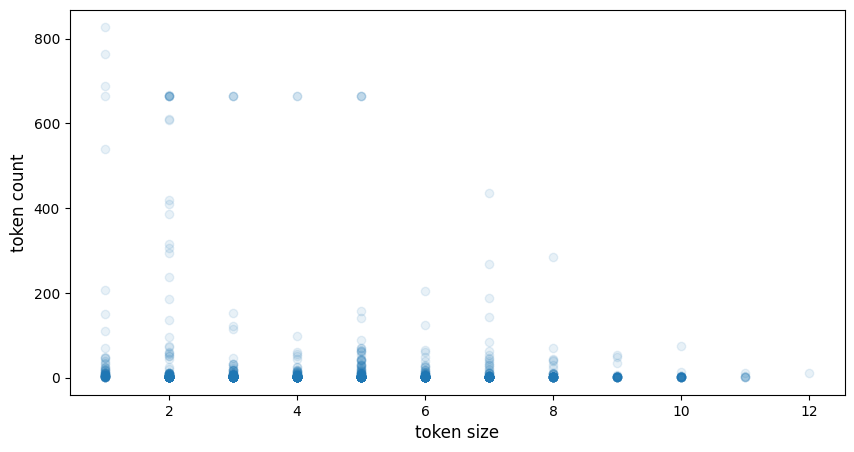

In [14]:
from matplotlib import pyplot as plt
import numpy as np
logger.add(options.base_path+'output/hearthstone-analyze.log')
train_data, valid_data, test_data, vocab_src, vocab_tgt=read_hearthstone_data()
data = []
for i in range(vocab_src.n_words):
    word = vocab_src.index2word[i]
    count = vocab_src.word2count[word]
    if count <1000:
        data.append([len(word), count])
    
data = np.array(data)

plt.figure(figsize=(10, 5))
plt.xlabel("token size", size=12)
plt.ylabel("token count", size=12)
plt.scatter(data[:,0], data[:,1], alpha=.1)
plt.show()